<div id='id0' />

# Modelo predictivo

El objetivo de este notebook es hacer una análisis predictivo sobre la posible evolución que las superficies de cultivo podrian tomar en función de las temperaturas y precipitaciones.

In [15]:

#pip install graphviz
#pip install pydot
#pip install shap
#pip install xgboost
#pip install opencv-python
#pip install -U scikit-learn 

1. [Imporatncia de las Variables](#id1)
    - [Decicion Tree](#id2)
    - [Random Forest](#id3)
2. [Optimización de los parametros en modelos Random Forest y XGBoost](#id54)
3. [Modelos](#id4)
    - [BARLEY](#id5)
        - [Regresión Lineal](#id6)
        - [K Nearest Neighbour Regressor](#id7)
        - [Random Forest](#id9)
        - [XGboost](#id10)
    - [CORN](#id11)
        - [Regresión Lineal](#id12)
        - [K Nearest Neighbour Regressor](#id13)
        - [Random Forest](#id15)
        - [XGboost](#id16)
    - [COTTON](#id17)
        - [Regresión Lineal](#id18)
        - [K Nearest Neighbour Regressor](#id19)
        - [Random Forest](#id21)
        - [XGboost](#id22)
    - [OATS](#id23)
        - [Regresión Lineal](#id24)
        - [K Nearest Neighbour Regressor](#id25)
        - [Random Forest](#id27)
        - [XGboost](#id28)
    - [SORHGHUM](#id29)
        - [Regresión Lineal](#id30)
        - [K Nearest Neighbour Regressor](#id31)
        - [Random Forest](#id33)
        - [XGboost](#id34)
    - [SOYBEANS](#id35)
        - [Regresión Lineal](#id36)
        - [K Nearest Neighbour Regressor](#id37)
        - [Random Forest](#id39)
        - [XGboost](#id40)
    - [WEATH](#id41)
        - [Regresión Lineal](#id42)
        - [K Nearest Neighbour Regressor](#id43)
        - [Random Forest](#id45)
        - [XGboost](#id46)
    - [GLOBAL](#id47)
        - [Regresión Lineal](#id48)
        - [K Nearest Neighbour Regressor](#id49)
        - [Random Forest](#id51)
        - [XGboost](#id52)
    - [Resumen y comparativa de los Modelos](#id54)
3. [Conclusiones](#id53)

In [1]:
#--BASE--#
%matplotlib inline
import pandas as pd
import warnings
import numpy as np
import datetime
import os
from datetime import timedelta
import functions # hoja de funciones creadas para este trabajo

#--VISUALIZACIÓN--#
import matplotlib as mpl
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from statsmodels.graphics.factorplots import interaction_plot
import graphviz 
import shap
import pydot

#--CONFIGURACIÓN--#
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
#style.use('ggplot') or plt.style.use('ggplot')

#--MODELOS--#
from sklearn.model_selection import train_test_split

[up](#id0)

<div id='id1' />

## Importancia de las variables

In [2]:
#variables diferenciadas por cultivos y año
df_crops = pd.read_csv('../DATOS/archivos creados analisis/variables_por_cultivos.csv')
df_crops.set_index('date', inplace=True)

#agrupación del las variables por año
df_agrupation = pd.read_csv('../DATOS/archivos creados analisis/variables_agrupadas.csv')
df_agrupation.set_index('date', inplace=True)

In [3]:
df_crops.head()

BARLEY_Prec  CORN_Prec  COTTON_Prec  OATS_Prec  SORGHUM_Prec  \
date                                                                 
1950        73.98      78.74        86.30      78.74         75.46   
1951        75.42      80.57        83.04      80.57         75.67   
1952        65.15      70.29        75.06      70.29         63.43   
1953        66.40      74.99        79.14      74.99         68.09   
1954        64.11      70.48        66.31      70.48         60.45   

      SOYBEANS_Prec  WHEAT_Prec  BARLEY_Temp  CORN_Temp  COTTON_Temp  \
date                                                                   
1950          88.53       75.43         9.92      10.51        15.08   
1951          88.68       75.97         9.94      10.59        15.06   
1952          77.93       65.44        10.68      11.21        15.30   
1953          80.63       67.08        11.58      11.81        15.72   
1954          72.83       62.88        11.40      11.53        15.89   

      OATS_Temp  SORGHUM_Temp  SOYBEANS_Temp  WHEAT_Temp  BARLEY_Ha  \
date                                                                  
1950      10.51         11.68          11.45       10.54 6018490.19   
1951      10.59         11.61          11.65       10.56 4917339.59   
1952      11.21         12.43          12.45       11.28 4249607.69   
1953      11.81         13.24          12.98       11.87 4450331.94   
1954      11.53         13.73          12.78       11.72 7049225.43   

         CORN_Ha   COTTON_Ha     OATS_Ha  SORGHUM_Ha  SOYBEANS_Ha    WHEAT_Ha  
date                                                                           
1950 36371963.62  8713779.89 18228676.18  6497233.73   6089714.93 86572428.27  
1951 36682357.78 13705824.51 16598196.29  6081621.21   6141514.74 97816264.56  
1952 36110536.47 13185276.91 17134809.93  4973186.25   6457979.19 97829230.70  
1953 35958374.53 21749120.64 17490528.92  5904368.74   6634422.28 97789595.75  
1954 36060355.40 16229365.47 18978964.03  8153613.53   7503283.13 77428337.66

In [4]:
df_agrupation.head()

Precipitation  Temperature      hectare
date                                         
1950          77.17        10.84 176249915.09
1951          77.93        10.88 189240699.91
1952          67.37        11.61 186406457.23
1953          71.33        12.20 197350485.94
1954          65.87        12.07 179788845.60

[up](#id0)

<div id='id2' />

### Decicion Tree
- Imagenes representada en el archivo: "../NOTEBOOKS/images/Decision_Tree/"

In [5]:
functions.Decision_Tree(df_crops[['BARLEY_Prec', 'BARLEY_Temp']], df_crops['BARLEY_Ha'], image_name = 'BARLEY')
functions.Decision_Tree(df_crops[['CORN_Prec', 'CORN_Temp']], df_crops['CORN_Ha'], image_name = 'CORN')
functions.Decision_Tree(df_crops[['COTTON_Prec', 'COTTON_Temp']], df_crops['COTTON_Ha'], image_name = 'COTTON')
functions.Decision_Tree(df_crops[['OATS_Prec', 'OATS_Temp']], df_crops['OATS_Ha'], image_name = 'OATS')
functions.Decision_Tree(df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']], df_crops['SORGHUM_Ha'], image_name = 'SOURGHUM')
functions.Decision_Tree(df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']], df_crops['SOYBEANS_Ha'], image_name = 'SOYBEANS')
functions.Decision_Tree(df_crops[['WHEAT_Prec', 'WHEAT_Temp']], df_crops['WHEAT_Ha'], image_name = 'WHEAT')

functions.Decision_Tree(df_agrupation[['Precipitation', 'Temperature']], df_agrupation['hectare'], image_name = 'Agrupation dataset')

[up](#id0)

<div id='id3' />

### Random Forest
- Imagenes representada en el archivo: ../NOTEBOOKS/images/Random_Forest/

In [21]:
functions.Random_Forest(df_crops[['BARLEY_Prec', 'BARLEY_Temp']], df_crops['BARLEY_Ha'], 'BARLEY', image_name = 'BARLEY')
functions.Random_Forest(df_crops[['CORN_Prec', 'CORN_Temp']], df_crops['CORN_Ha'], 'CORN', image_name = 'CORN')
functions.Random_Forest(df_crops[['COTTON_Prec', 'COTTON_Temp']], df_crops['COTTON_Ha'], 'COTTON', image_name = 'COTTON')
functions.Random_Forest(df_crops[['OATS_Prec', 'OATS_Temp']], df_crops['OATS_Ha'], 'OATS', image_name = 'OATS')
functions.Random_Forest(df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']], df_crops['SORGHUM_Ha'], 'SOURGHUM', image_name = 'SOURGHUM')
functions.Random_Forest(df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']], df_crops['SOYBEANS_Ha'], 'SOYBEANS', image_name = 'SOYBEANS')
functions.Random_Forest(df_crops[['WHEAT_Prec', 'WHEAT_Temp']], df_crops['WHEAT_Ha'], 'WHEAT', image_name = 'WHEAT')

functions.Random_Forest(df_agrupation[['Precipitation', 'Temperature']], df_agrupation['hectare'], 'Agrupation dataset', image_name = 'Agrupation dataset')

[up](#id0)

<div id='id54' />

## Optimización de los parametros en modelos Random Forest y XGBoost

In [22]:
#BARLEY
#Selección de variables
X = df_crops[['BARLEY_Prec', 'BARLEY_Temp']] 
y = df_crops['BARLEY_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [23]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1}


In [24]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 10}


In [25]:
#CORN
#Selección de variables
X = df_crops[['CORN_Prec', 'CORN_Temp']] 
y = df_crops['CORN_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [26]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}


In [27]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 10}


In [28]:
#COTTON
#Selección de variables
X = df_crops[['COTTON_Prec', 'COTTON_Temp']] 
y = df_crops['COTTON_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [29]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1}


In [30]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 50}


In [31]:
#OATS
#Selección de variables
X = df_crops[['OATS_Prec', 'OATS_Temp']] 
y = df_crops['OATS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [32]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}


In [33]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 3}


In [34]:
#SORGHUM
#Selección de variables
X = df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']] 
y = df_crops['SORGHUM_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [35]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'poisson', 'max_depth': 1, 'max_features': 'log2', 'n_estimators': 1}


In [36]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 10}


In [37]:
#SOYBEANS
#Selección de variables
X = df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']] 
y = df_crops['SOYBEANS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [38]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 10}


In [39]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'absolute_error', 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 5}


In [40]:
#WHEAT
#Selección de variables
X = df_crops[['WHEAT_Prec', 'WHEAT_Temp']] 
y = df_crops['WHEAT_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [41]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'squared_error', 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 3}


In [42]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 5}


In [43]:
#AGRUPATION
#Selección de variables
X = df_agrupation[['Precipitation', 'Temperature']]
y = df_agrupation['hectare']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

((54, 2), (18, 2))

In [44]:
functions.Random_Forest_Tuning(X_train, y_train)

Random Forest Parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1}


In [45]:
functions.XGBoost_Tuning(X_train, y_train)

XGBoost parameters: {'gamma': 1e-05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 5}


[up](#id0)

<div id='id4' />

## Modelos

Para la creación de las variables de train y test no se indica una selección de datos aleatorios que estan ordenador por fecha

[up](#id0)

<div id='id4' />

### BARLEY

<div id='id5' />

#### Linear Regresion

(MAE) Test Mean absolute error: 5653825.79
(MSE) Test mean squared error: 2377.78
Test R2 score: -63.09


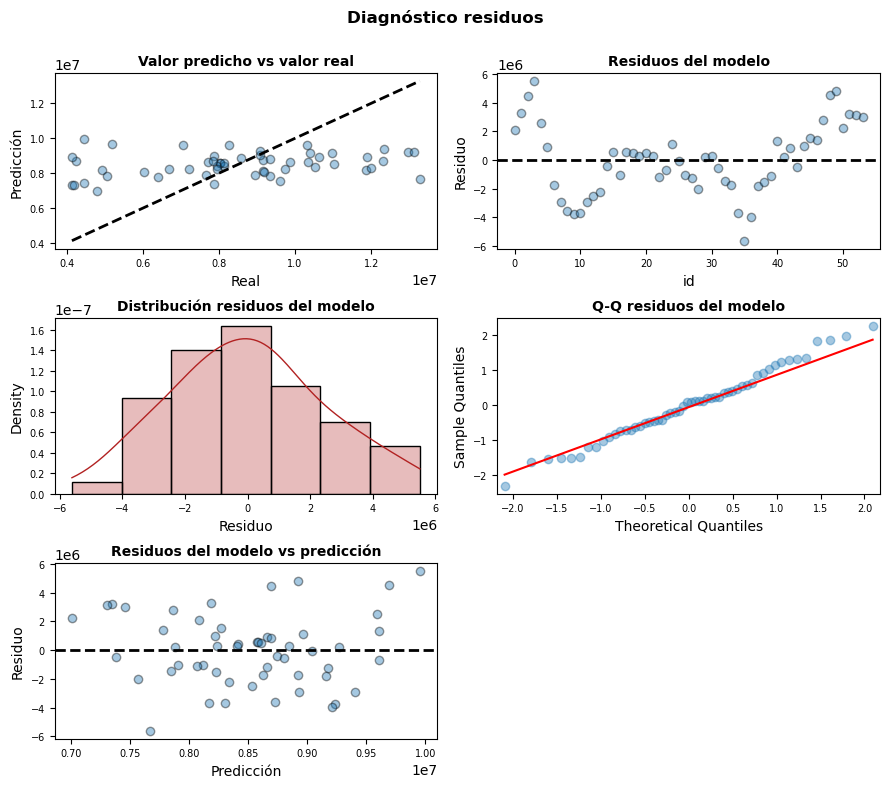

In [5]:
#Selección de variables
X = df_crops[['BARLEY_Prec', 'BARLEY_Temp']] 
y = df_crops['BARLEY_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id6' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 7002686.54
(MSE) Test mean squared error: 2646.26
Test R2 score: -99.61


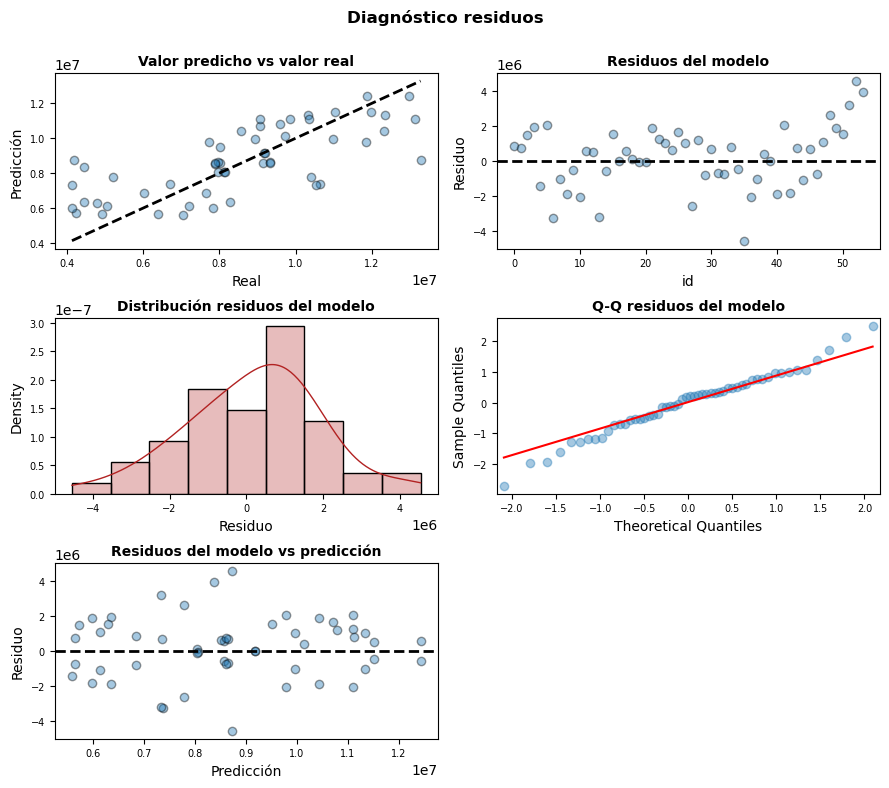

In [6]:
#Selección de variables
X = df_crops[['BARLEY_Prec', 'BARLEY_Temp']] 
y = df_crops['BARLEY_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id8' />

#### Random Forest

(MAE) Test Mean absolute error: 5636114.118
(MSE) Test mean squared error: 2374.05
Test R2 score: -65.91
-0.07995114281470994


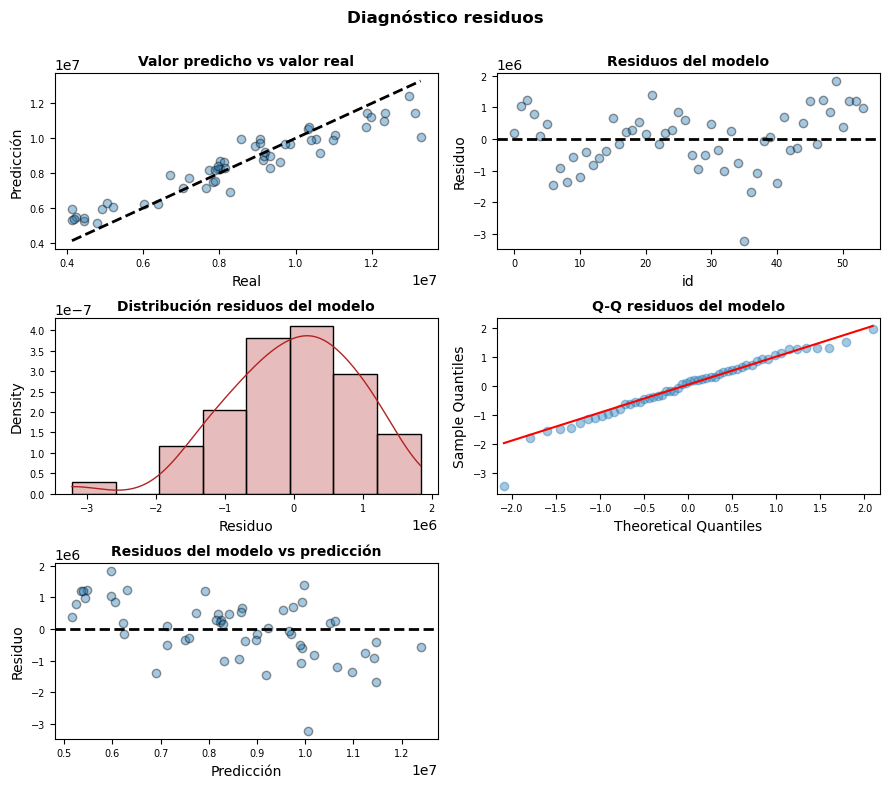

In [7]:
#Selección de variables
X = df_crops[['BARLEY_Prec', 'BARLEY_Temp']] 
y = df_crops['BARLEY_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='absolute_error', max_depth= 2, max_features='sqrt', n_estimators= 1)

[up](#id0)

<div id='id9' />

#### XGboost

(MAE) Test Mean absolute error: 5541341.328
(MSE) Test mean squared error: 2354.005
Test R2 score: -68.918


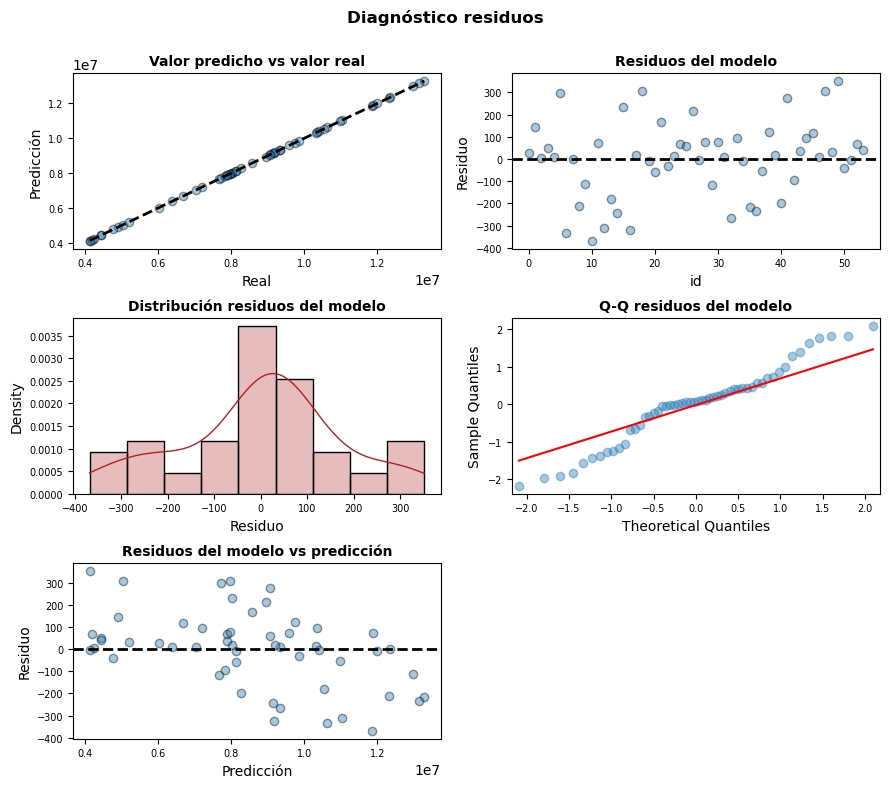

In [8]:
#Selección de variables
X = df_crops[['BARLEY_Prec', 'BARLEY_Temp']] 
y = df_crops['BARLEY_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 1, min_child_weight = 6, n_estimators = 10)

[up](#id0)

<div id='id11' />

### CORN

<div id='id12' />

#### Linear Regresion

(MAE) Test Mean absolute error: 5884698.85
(MSE) Test mean squared error: 2425.84
Test R2 score: -3.64


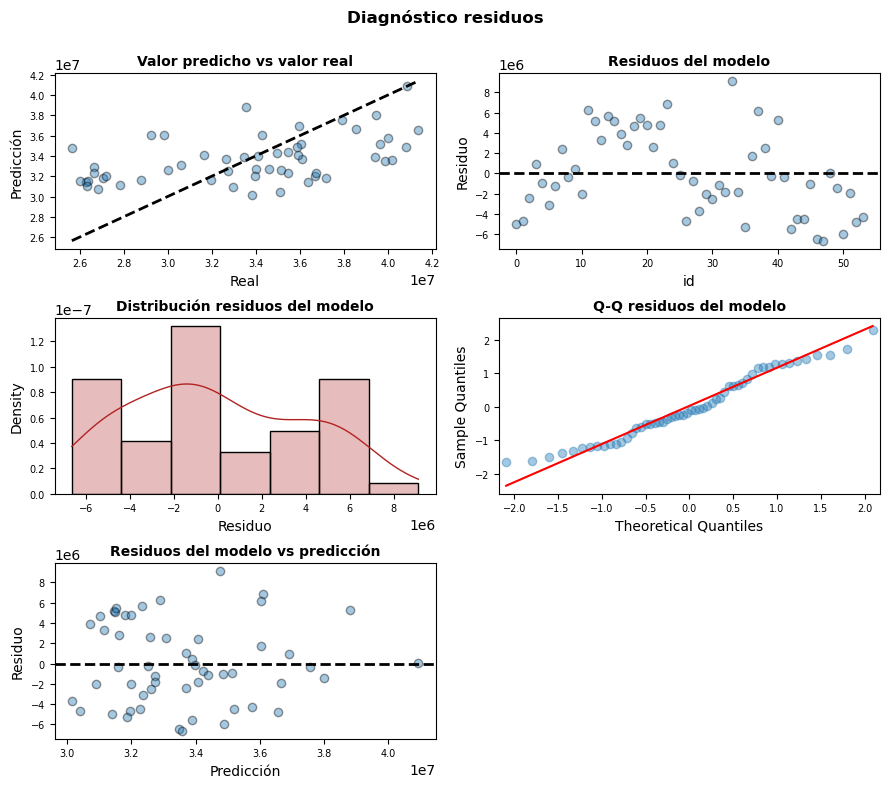

In [9]:
#Selección de variables
X = df_crops[['CORN_Prec', 'CORN_Temp']] 
y = df_crops['CORN_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id13' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 7213471.74
(MSE) Test mean squared error: 2685.79
Test R2 score: -5.85


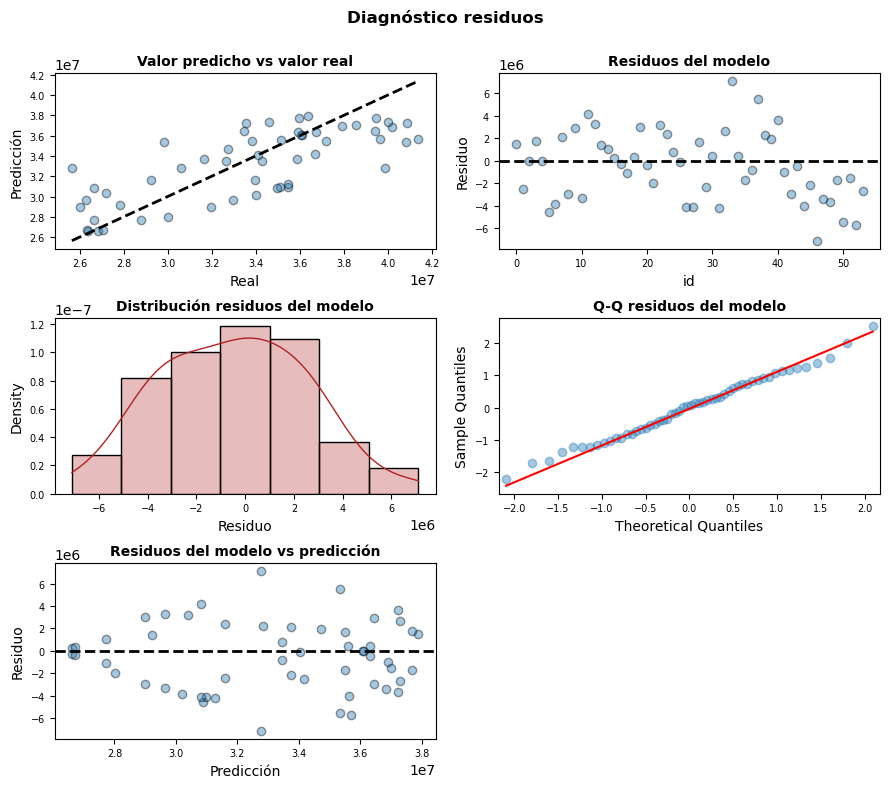

In [10]:
#Selección de variables
X = df_crops[['CORN_Prec', 'CORN_Temp']] 
y = df_crops['CORN_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id15' />

#### Random Forest

(MAE) Test Mean absolute error: 6444136.454
(MSE) Test mean squared error: 2538.53
Test R2 score: -4.268
0.03843797348897471


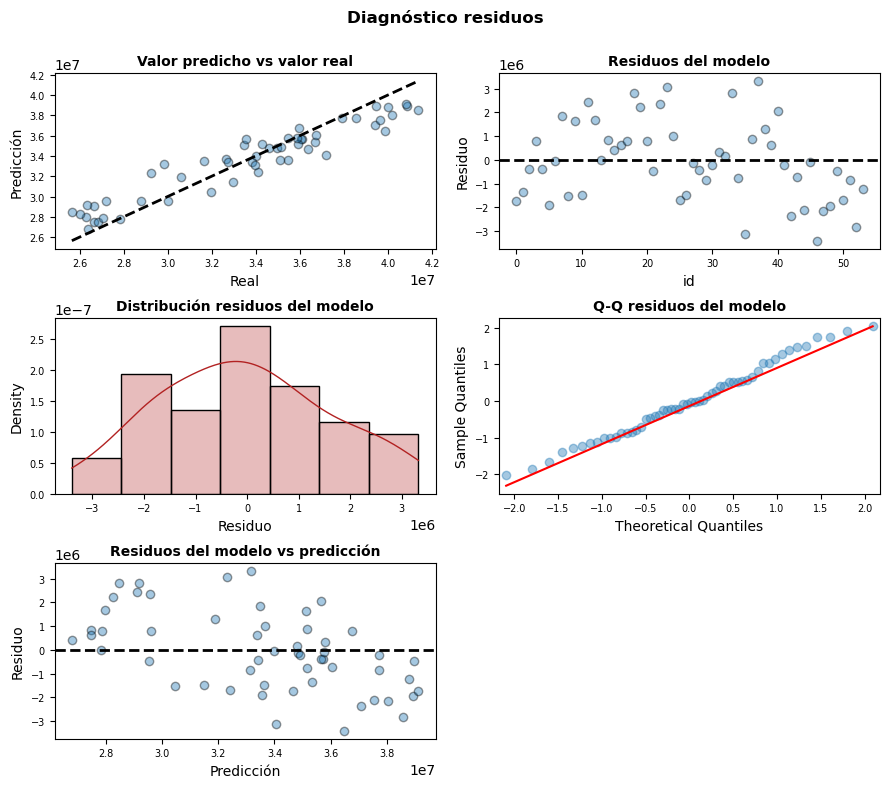

In [11]:
#Selección de variables
X = df_crops[['CORN_Prec', 'CORN_Temp']] 
y = df_crops['CORN_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='absolute_error', max_depth= 5, max_features='auto', n_estimators= 10)

[up](#id0)

<div id='id16' />

#### XGboost

(MAE) Test Mean absolute error: 7030400.704
(MSE) Test mean squared error: 2651.49
Test R2 score: -6.481


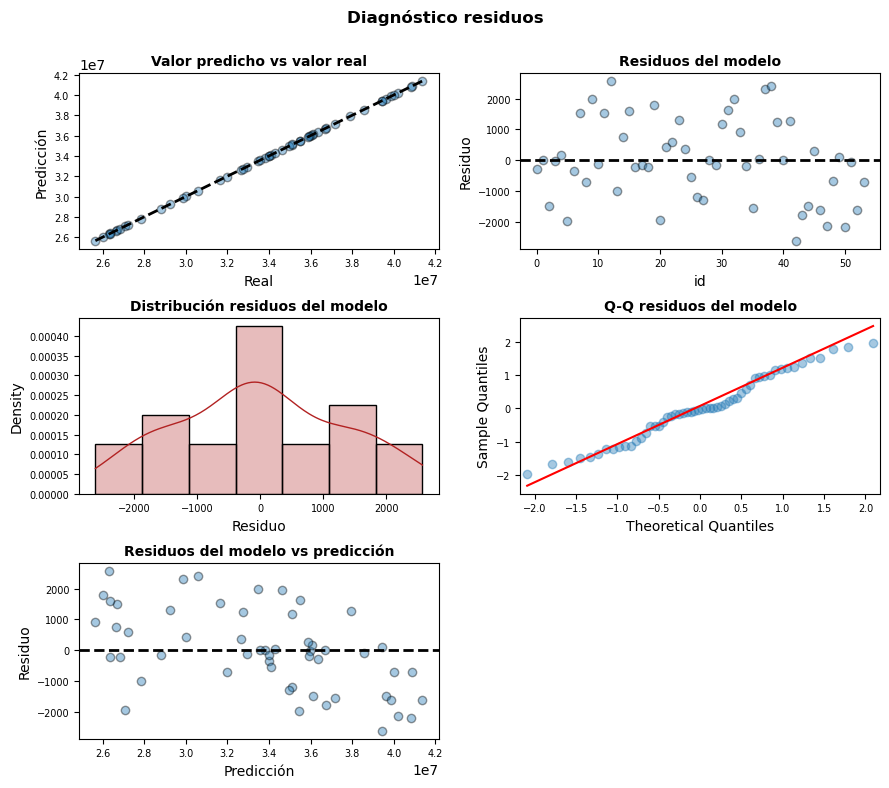

In [12]:
#Selección de variables
X = df_crops[['CORN_Prec', 'CORN_Temp']] 
y = df_crops['CORN_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 8, min_child_weight = 3, n_estimators = 10)

[up](#id0)

<div id='id17' />

### COTTON

<div id='id18' />

#### Linear Regresion

(MAE) Test Mean absolute error: 3866640.06
(MSE) Test mean squared error: 1966.38
Test R2 score: -3.16


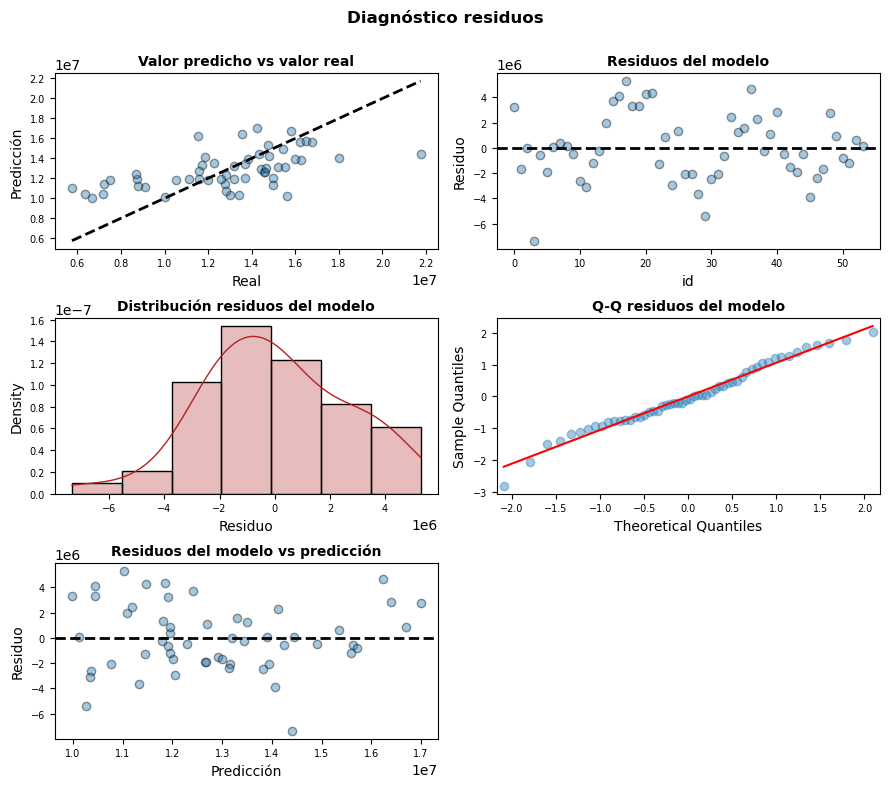

In [13]:
#Selección de variables
X = df_crops[['COTTON_Prec', 'COTTON_Temp']] 
y = df_crops['COTTON_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id19' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 3643654.48
(MSE) Test mean squared error: 1908.84
Test R2 score: -2.01


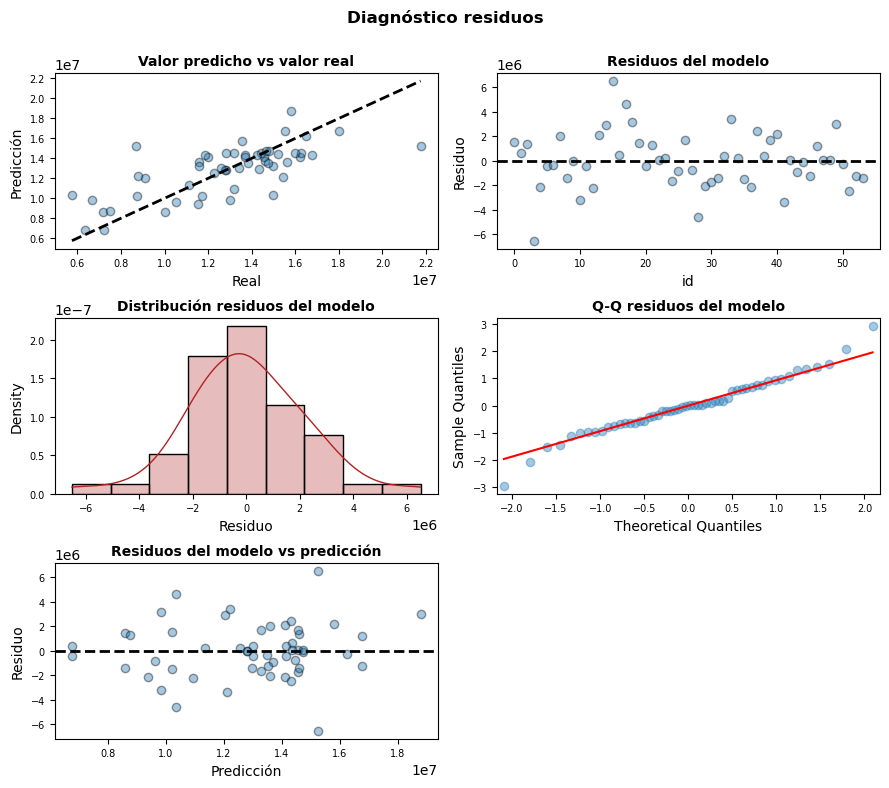

In [14]:
#Selección de variables
X = df_crops[['COTTON_Prec', 'COTTON_Temp']] 
y = df_crops['COTTON_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id21' />

#### Random Forest

(MAE) Test Mean absolute error: 3055967.624
(MSE) Test mean squared error: 1748.133
Test R2 score: -1.481
0.0714733284515322


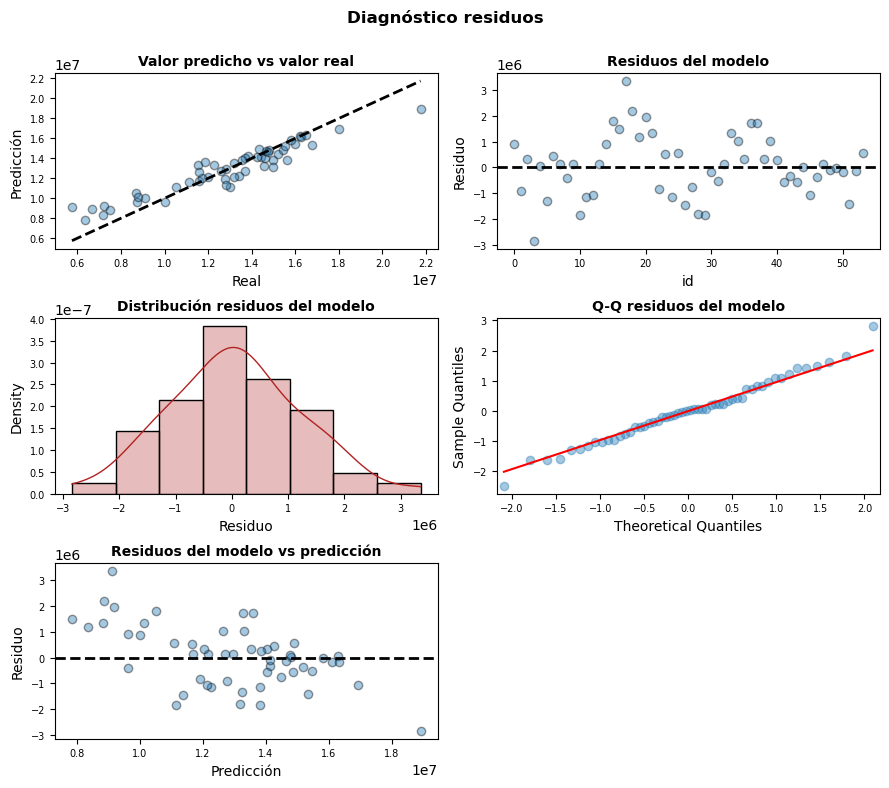

In [15]:
#Selección de variables
X = df_crops[['COTTON_Prec', 'COTTON_Temp']] 
y = df_crops['COTTON_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='squared_error', max_depth= 2, max_features='sqrt', n_estimators= 1)

[up](#id0)

<div id='id22' />

#### XGboost

(MAE) Test Mean absolute error: 3481060.11
(MSE) Test mean squared error: 1865.76
Test R2 score: -2.558


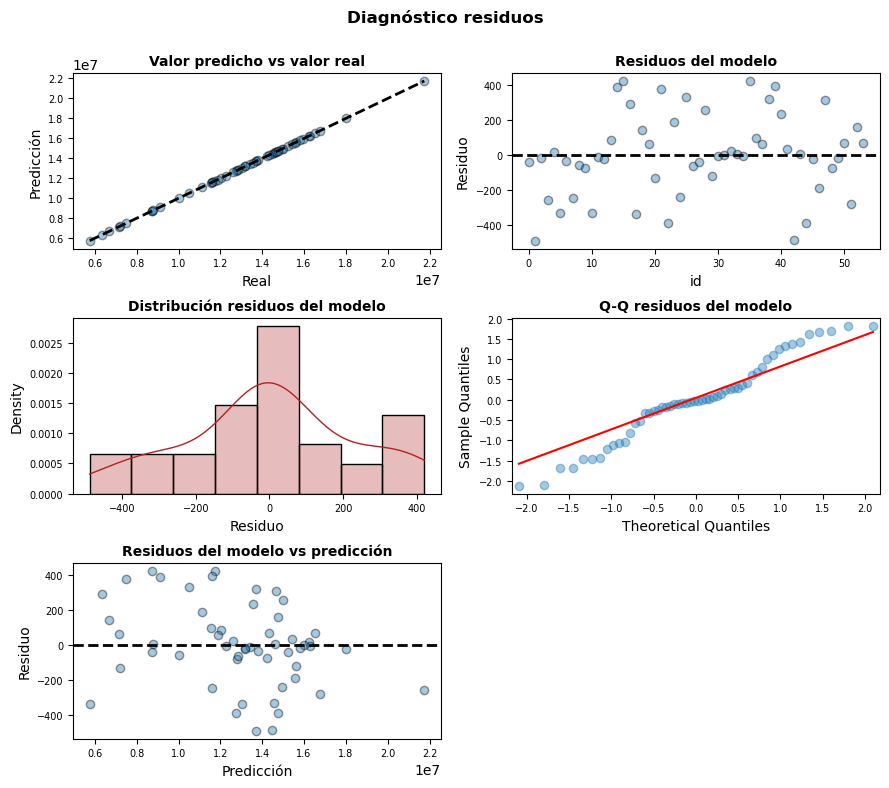

In [16]:
#Selección de variables
X = df_crops[['COTTON_Prec', 'COTTON_Temp']] 
y = df_crops['COTTON_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 1, min_child_weight = 6, n_estimators = 50)

[up](#id0)

<div id='id23' />

### OATS

<div id='id24' />

#### Linear Regresion

(MAE) Test Mean absolute error: 6792566.94
(MSE) Test mean squared error: 2606.26
Test R2 score: -592.33


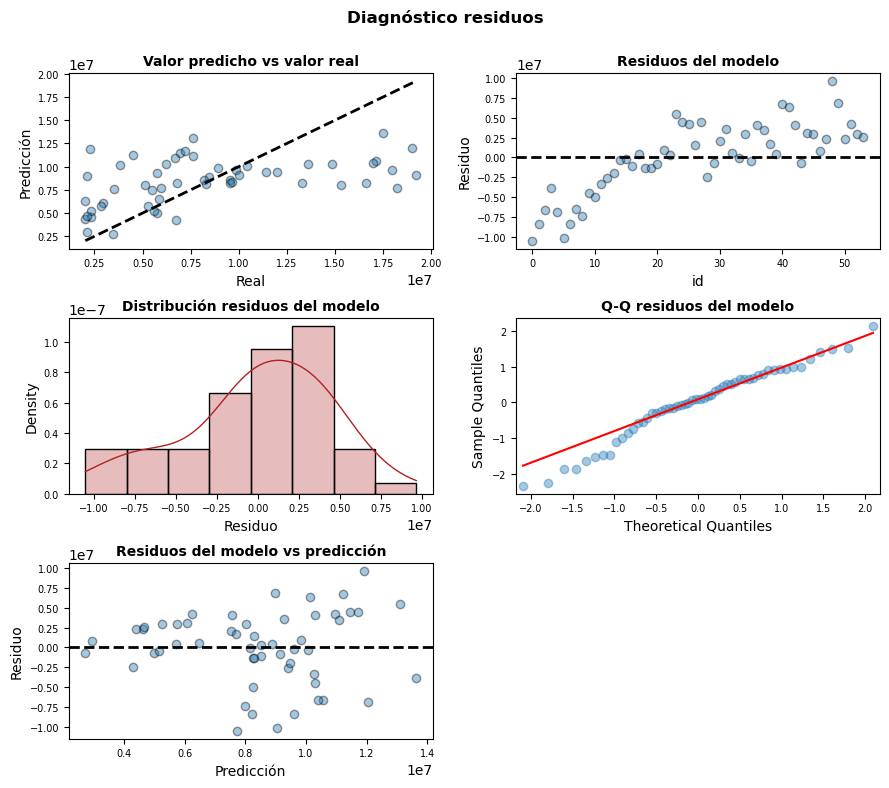

In [17]:
#Selección de variables
X = df_crops[['OATS_Prec', 'OATS_Temp']] 
y = df_crops['OATS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id25' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 7554486.02
(MSE) Test mean squared error: 2748.54
Test R2 score: -855.56


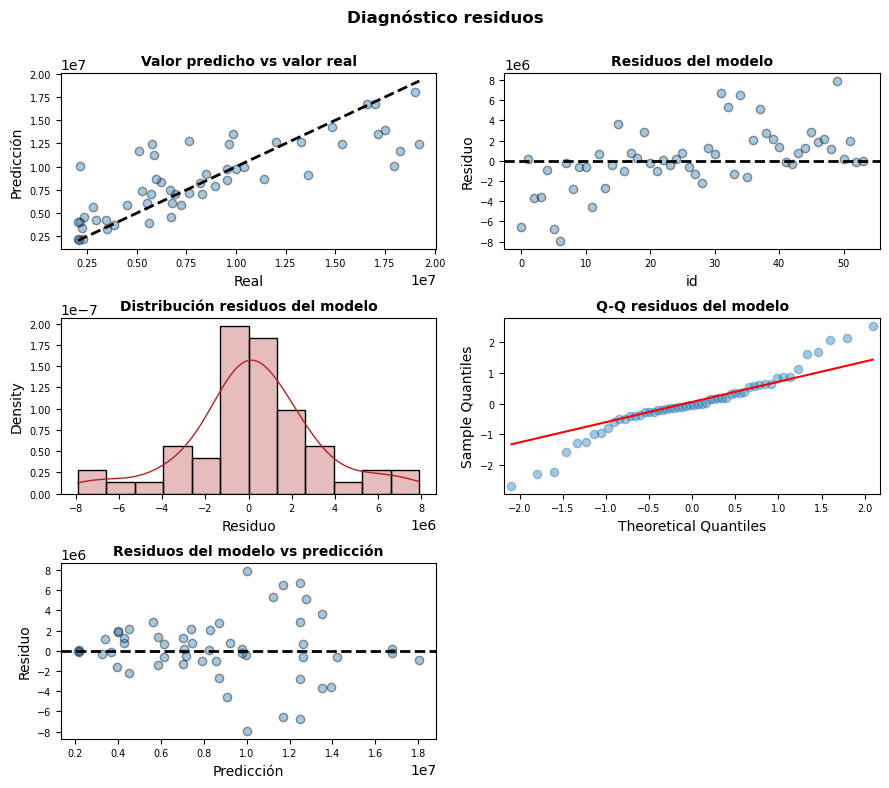

In [18]:
#Selección de variables
X = df_crops[['OATS_Prec', 'OATS_Temp']] 
y = df_crops['OATS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id27' />

#### Random Forest

(MAE) Test Mean absolute error: 6814138.053
(MSE) Test mean squared error: 2610.39
Test R2 score: -629.357
0.05455988356449648


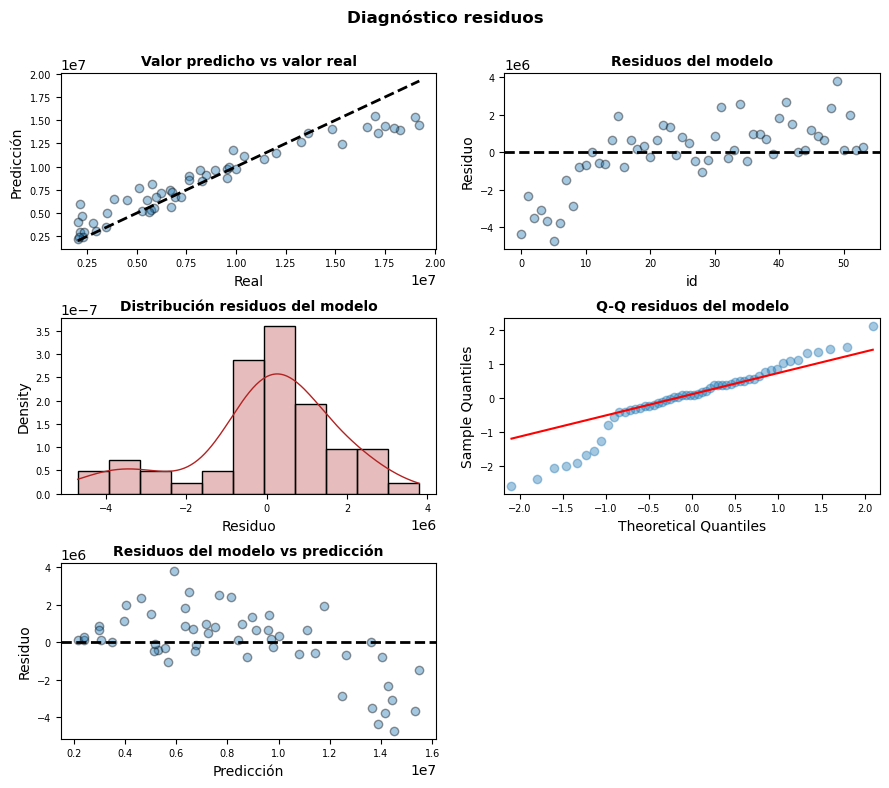

In [19]:
#Selección de variables
X = df_crops[['OATS_Prec', 'OATS_Temp']] 
y = df_crops['OATS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='squared_error', max_depth= 5, max_features='auto', n_estimators= 10)

[up](#id0)

<div id='id28' />

#### XGboost

(MAE) Test Mean absolute error: 6728577.807
(MSE) Test mean squared error: 2593.95
Test R2 score: -644.386


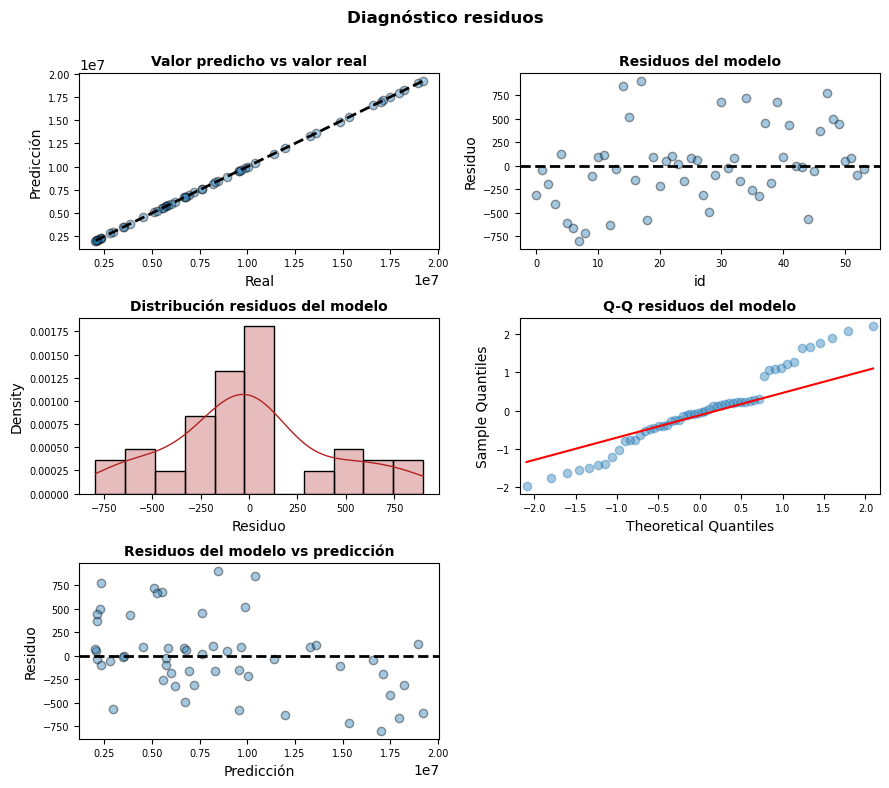

In [20]:
#Selección de variables
X = df_crops[['OATS_Prec', 'OATS_Temp']] 
y = df_crops['OATS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 4, min_child_weight = 5, n_estimators = 3)

[up](#id0)

<div id='id29' />

### SOURGHUM

<div id='id30' />

#### Linear Regresion

(MAE) Test Mean absolute error: 4412091.05
(MSE) Test mean squared error: 2100.5
Test R2 score: -11.71


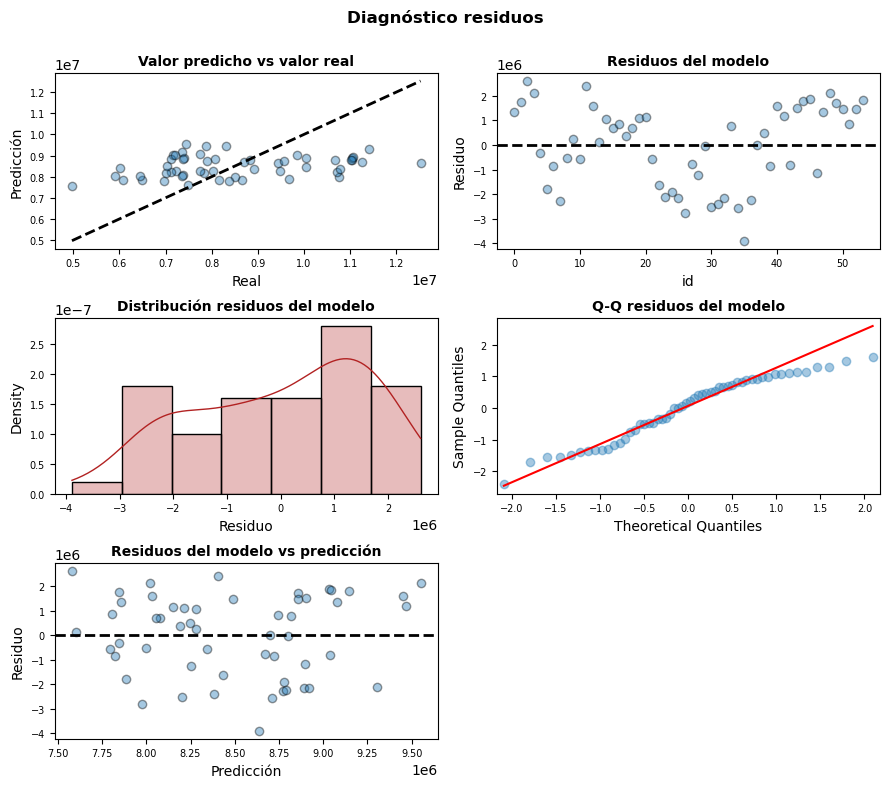

In [21]:
X = df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']] 
y = df_crops['SORGHUM_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id31' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 4706037.29
(MSE) Test mean squared error: 2169.34
Test R2 score: -13.53


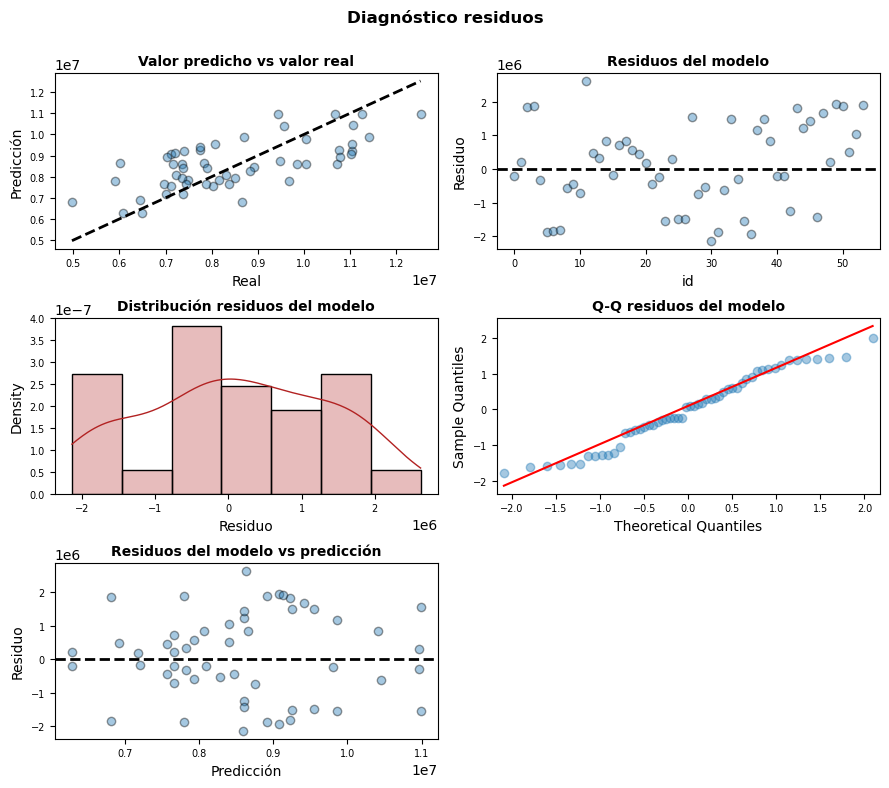

In [22]:
#Selección de variables
X = df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']] 
y = df_crops['SORGHUM_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id33' />

#### Random Forest

(MAE) Test Mean absolute error: 4467744.456
(MSE) Test mean squared error: 2113.704
Test R2 score: -11.966
-0.051473404478298956


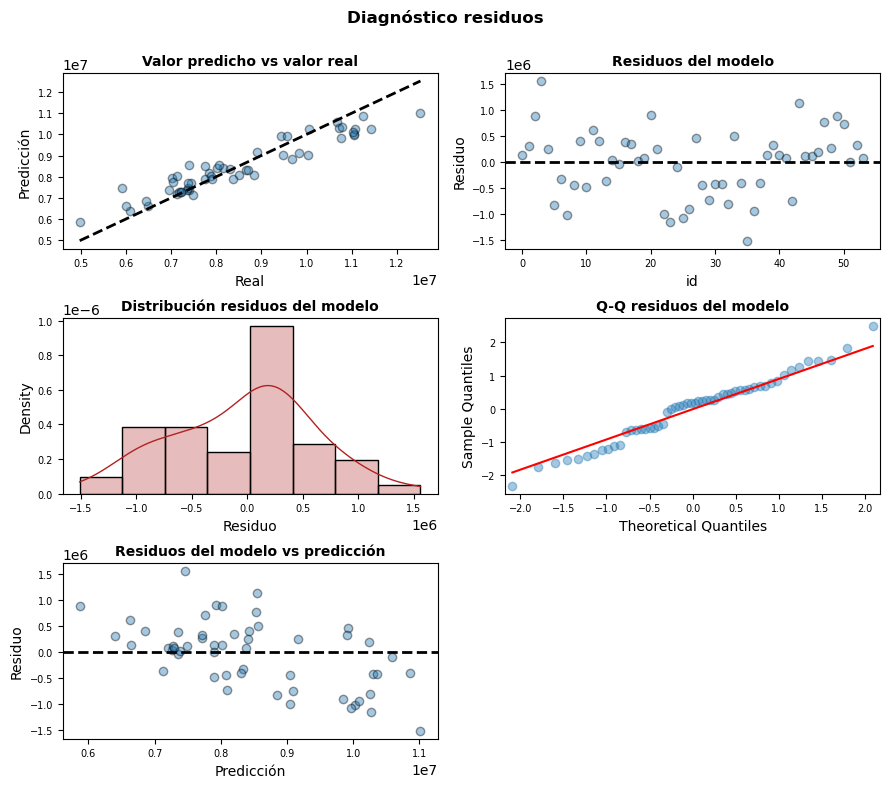

In [23]:
#Selección de variables
X = df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']] 
y = df_crops['SORGHUM_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='poisson', max_depth= 1, max_features='log2', n_estimators= 1)

[up](#id0)

<div id='id34' />

#### XGboost

(MAE) Test Mean absolute error: 4320066.099
(MSE) Test mean squared error: 2078.477
Test R2 score: -11.311


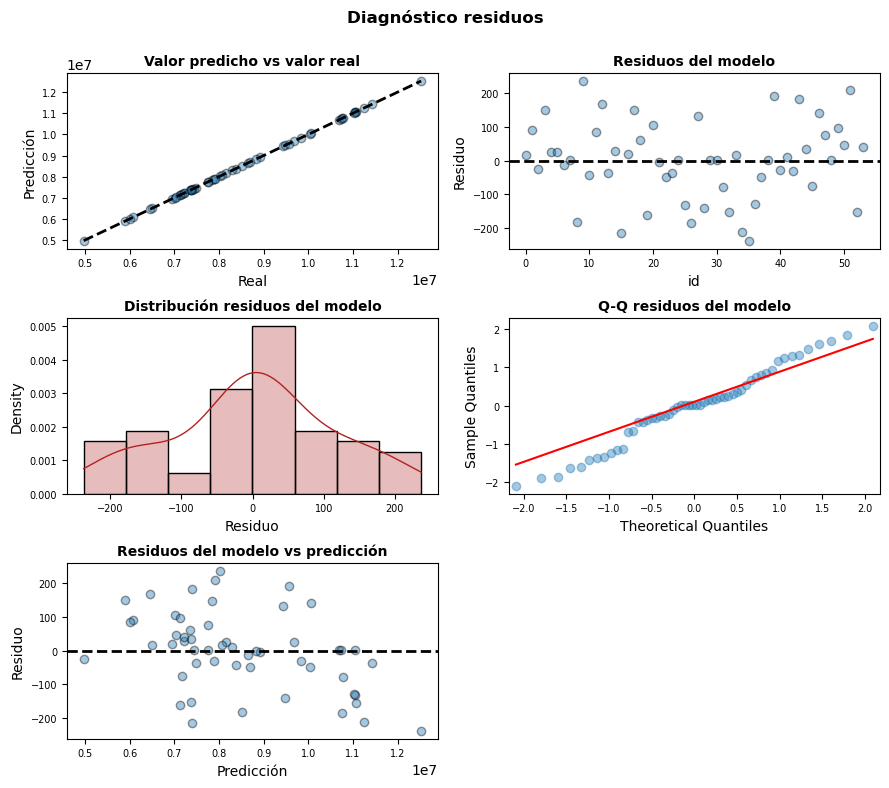

In [24]:
#Selección de variables
X = df_crops[['SORGHUM_Prec', 'SORGHUM_Temp']] 
y = df_crops['SORGHUM_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 3, min_child_weight = 6, n_estimators = 10)

[up](#id0)

<div id='id35' />

### SOYBEANS

<div id='id36' />

#### Linear Regresion

(MAE) Test Mean absolute error: 7137175.84
(MSE) Test mean squared error: 2671.55
Test R2 score: -8.06


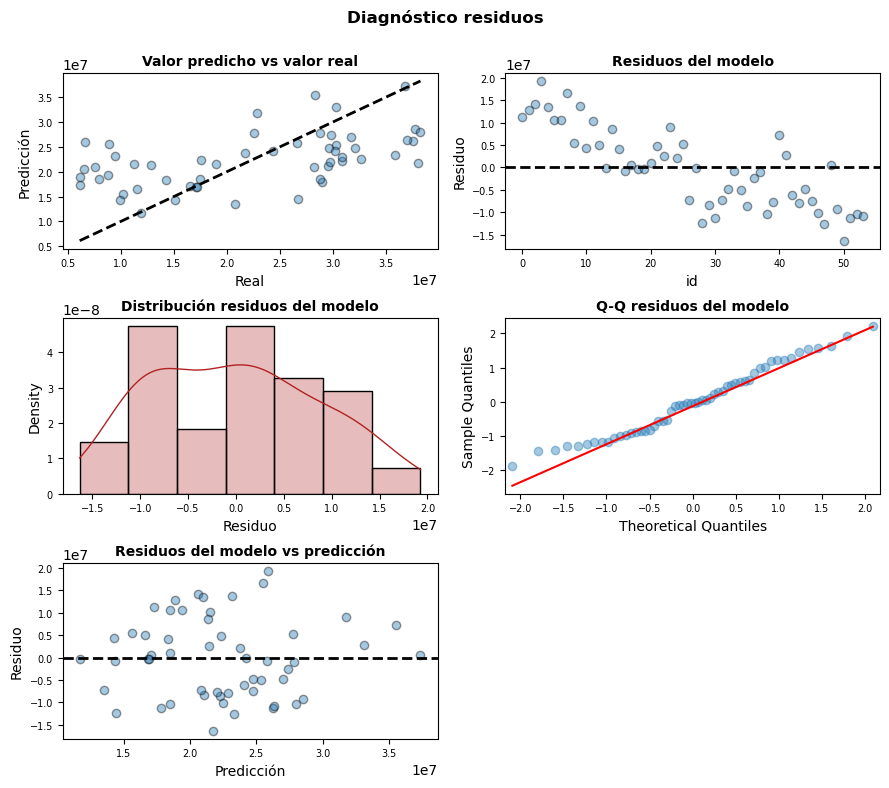

In [25]:
#Selección de variables
X = df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']] 
y = df_crops['SOYBEANS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id37' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 7759280.74
(MSE) Test mean squared error: 2785.55
Test R2 score: -9.78


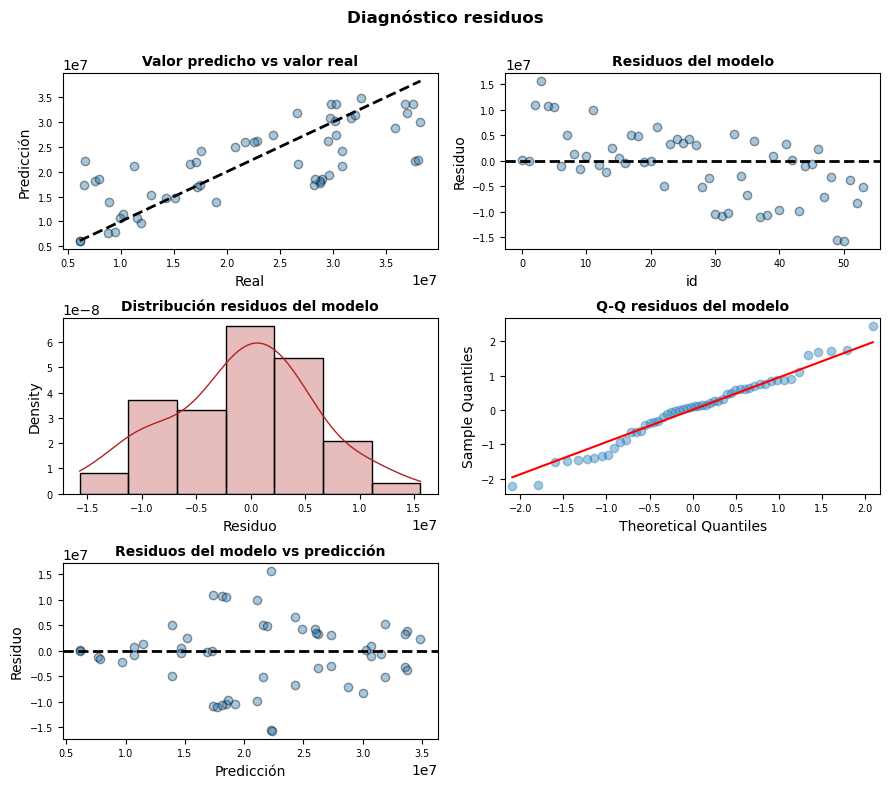

In [26]:
#Selección de variables
X = df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']] 
y = df_crops['SOYBEANS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id39' />

#### Random Forest

(MAE) Test Mean absolute error: 9363887.264
(MSE) Test mean squared error: 3060.047
Test R2 score: -12.492
-0.15299309067351374


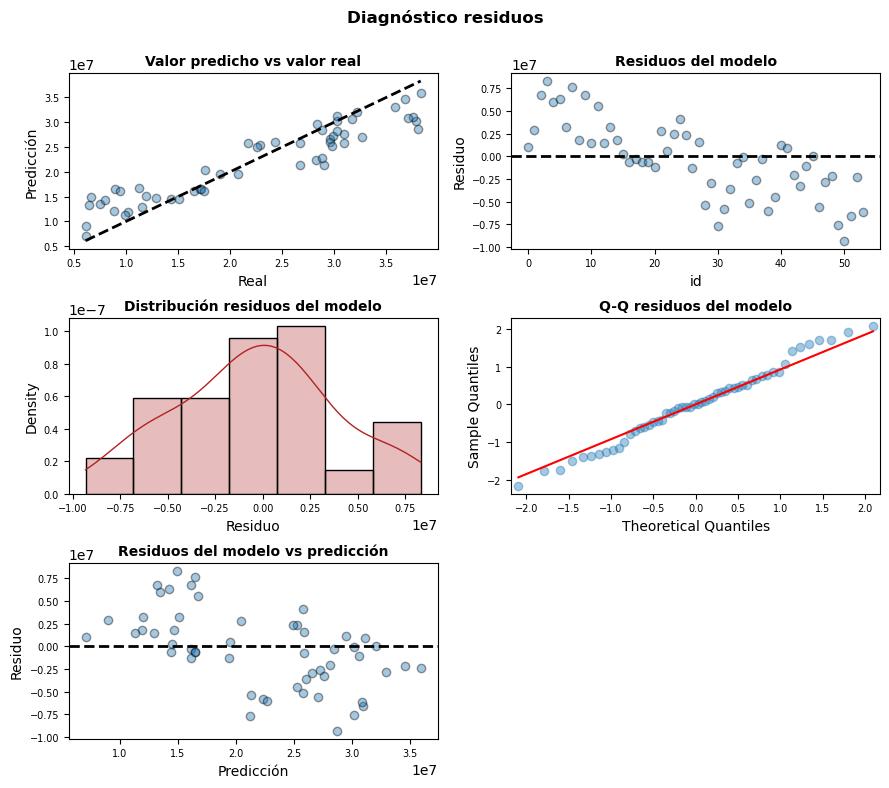

In [27]:
#Selección de variables
X = df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']] 
y = df_crops['SOYBEANS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='absolute_error', max_depth= 1, max_features='auto', n_estimators= 5)

[up](#id0)

<div id='id40' />

#### XGboost

(MAE) Test Mean absolute error: 9879845.191
(MSE) Test mean squared error: 3143.222
Test R2 score: -17.055


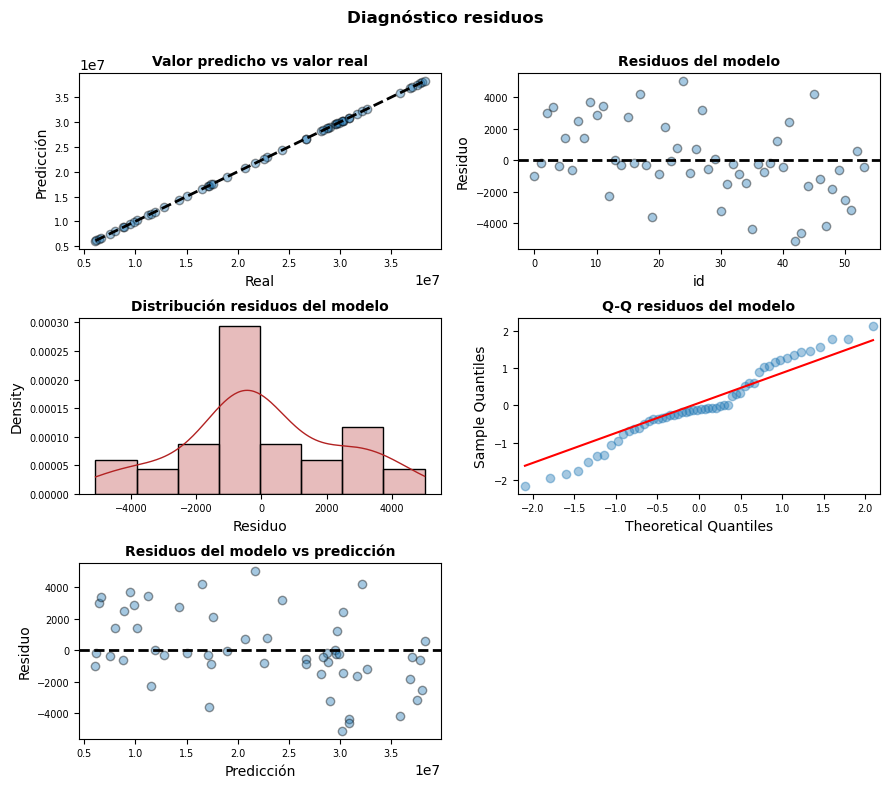

In [28]:
#Selección de variables
X = df_crops[['SOYBEANS_Prec', 'SOYBEANS_Temp']] 
y = df_crops['SOYBEANS_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 1, min_child_weight = 6, n_estimators = 10)

[up](#id0)

<div id='id41' />

### WHEAT

<div id='id42' />

#### Linear Regresion

(MAE) Test Mean absolute error: 69440009.27
(MSE) Test mean squared error: 8333.07
Test R2 score: -12.49


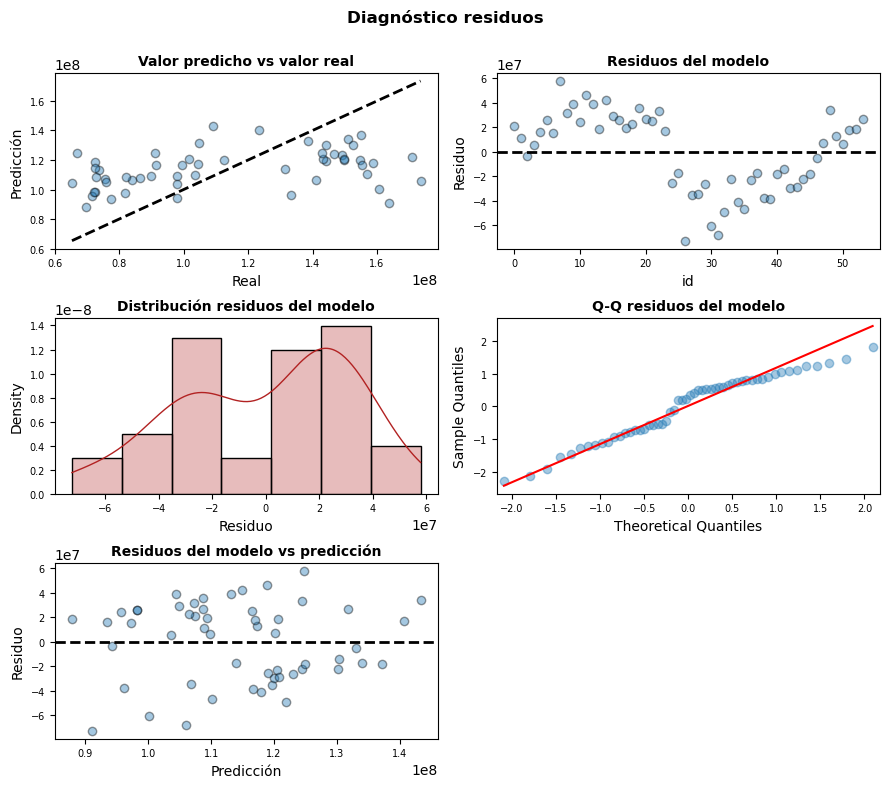

In [29]:
#Selección de variables
X = df_crops[['WHEAT_Prec', 'WHEAT_Temp']] 
y = df_crops['WHEAT_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id43' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 66399203.26
(MSE) Test mean squared error: 8148.57
Test R2 score: -12.2


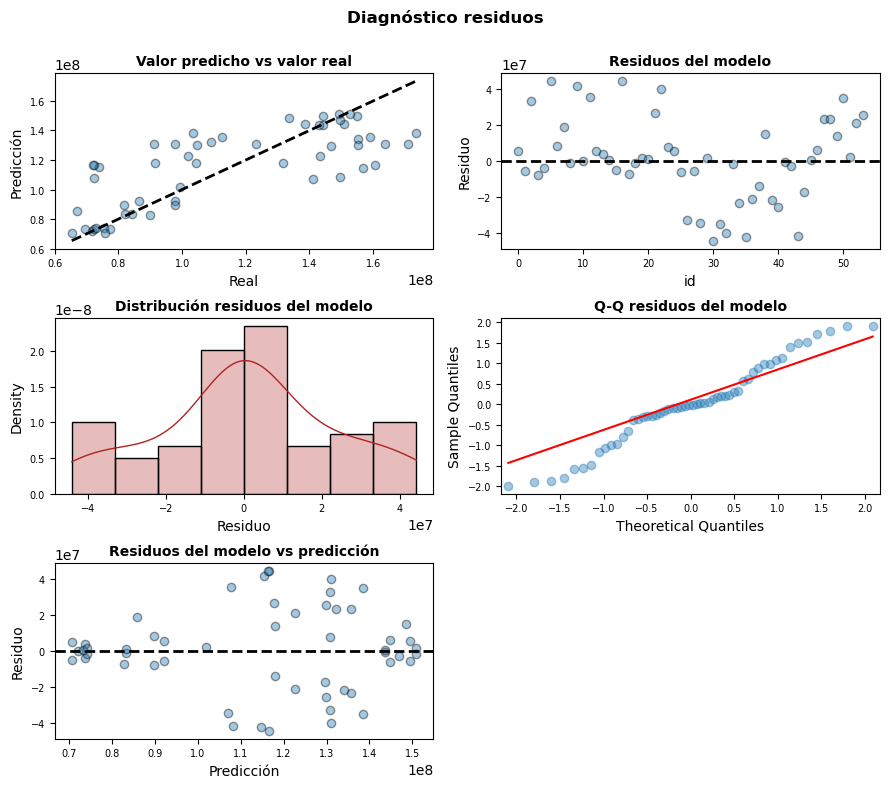

In [30]:
#Selección de variables
X = df_crops[['WHEAT_Prec', 'WHEAT_Temp']] 
y = df_crops['WHEAT_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id45' />

#### Random Forest

(MAE) Test Mean absolute error: 64572198.536
(MSE) Test mean squared error: 8035.683
Test R2 score: -10.53
-0.22045520509850514


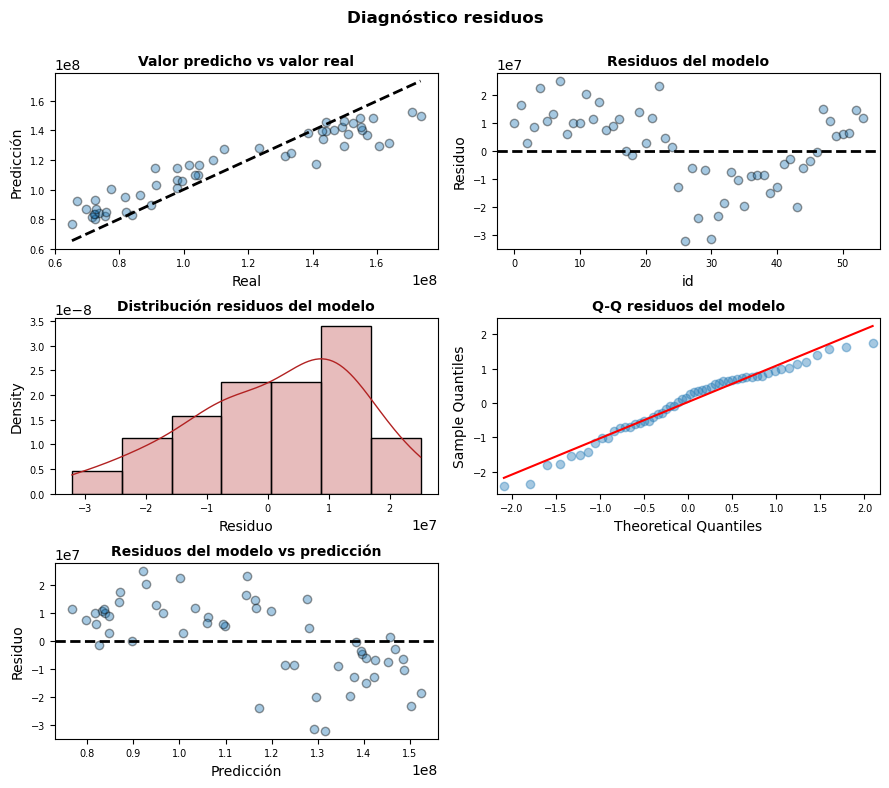

In [31]:
#Selección de variables
X = df_crops[['WHEAT_Prec', 'WHEAT_Temp']] 
y = df_crops['WHEAT_Ha']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='squared_error', max_depth= 1, max_features='auto', n_estimators= 3)

[up](#id0)

<div id='id46' />

#### XGboost

(MAE) Test Mean absolute error: 57293014.157
(MSE) Test mean squared error: 7569.215
Test R2 score: -8.507


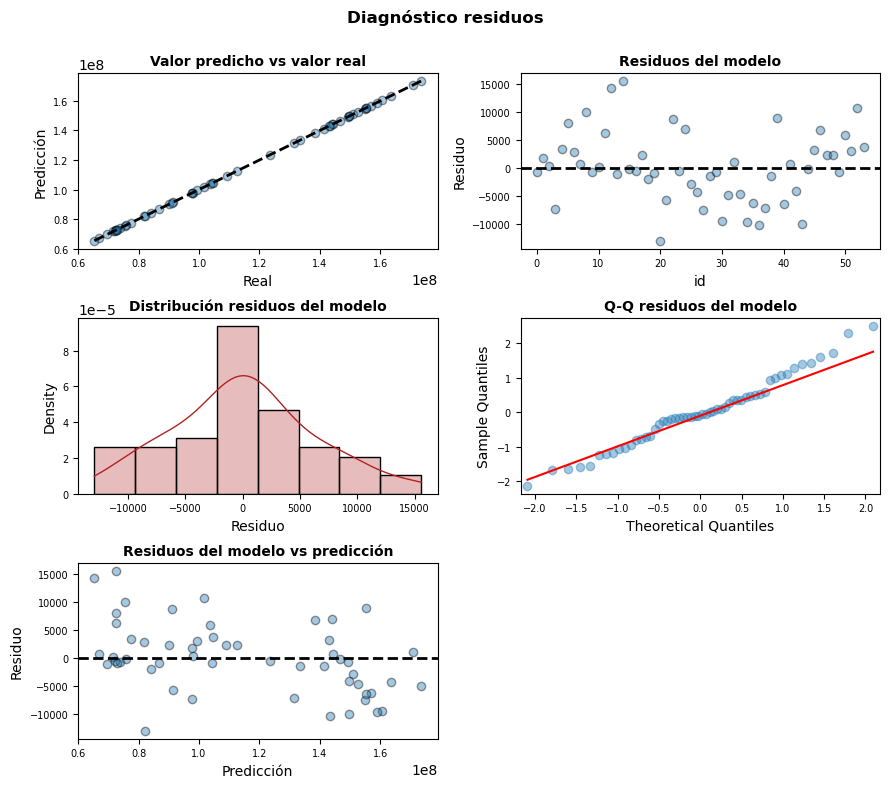

In [32]:
#Selección de variables
X = df_crops[['WHEAT_Prec', 'WHEAT_Temp']] 
y = df_crops['WHEAT_Ha']
#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 1, min_child_weight = 5, n_estimators = 5)

[up](#id0)

<div id='id47' />

### GLOBAL

<div id='id48' />

#### Linear Regresion

(MAE) Test Mean absolute error: 68011822.91
(MSE) Test mean squared error: 8246.93
Test R2 score: -8.27


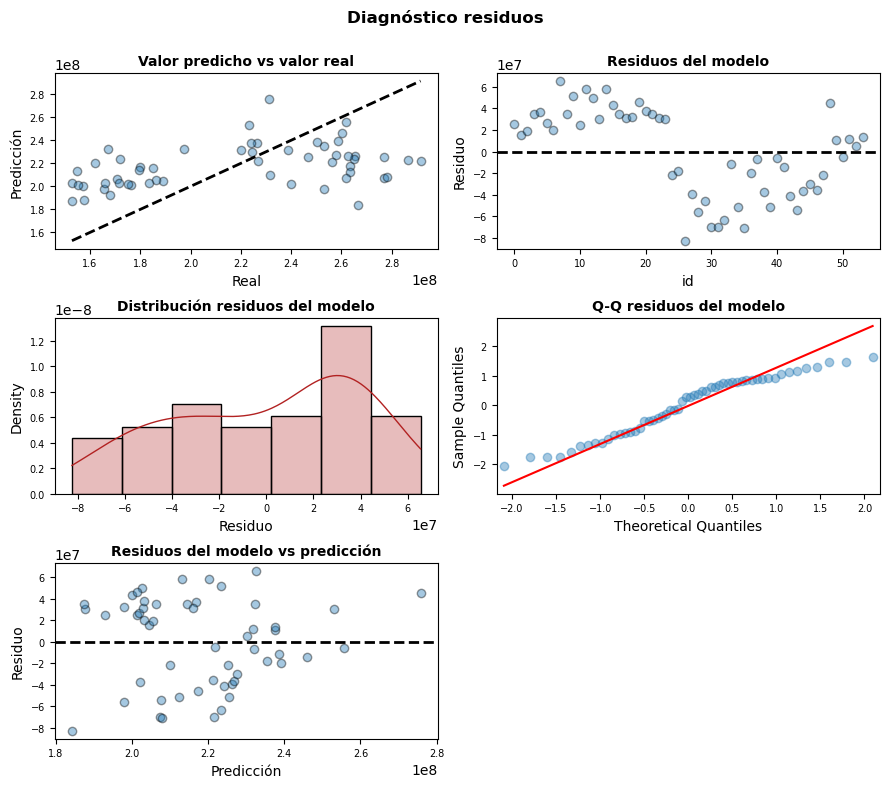

In [33]:
#Selección de variables
X = df_agrupation[['Precipitation', 'Temperature']]
y = df_agrupation['hectare']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Linear_Regression(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id49' />

#### K Nearest Neighbour Regressor

(MAE) Test Mean absolute error: 55857893.72
(MSE) Test mean squared error: 7473.81
Test R2 score: -5.64


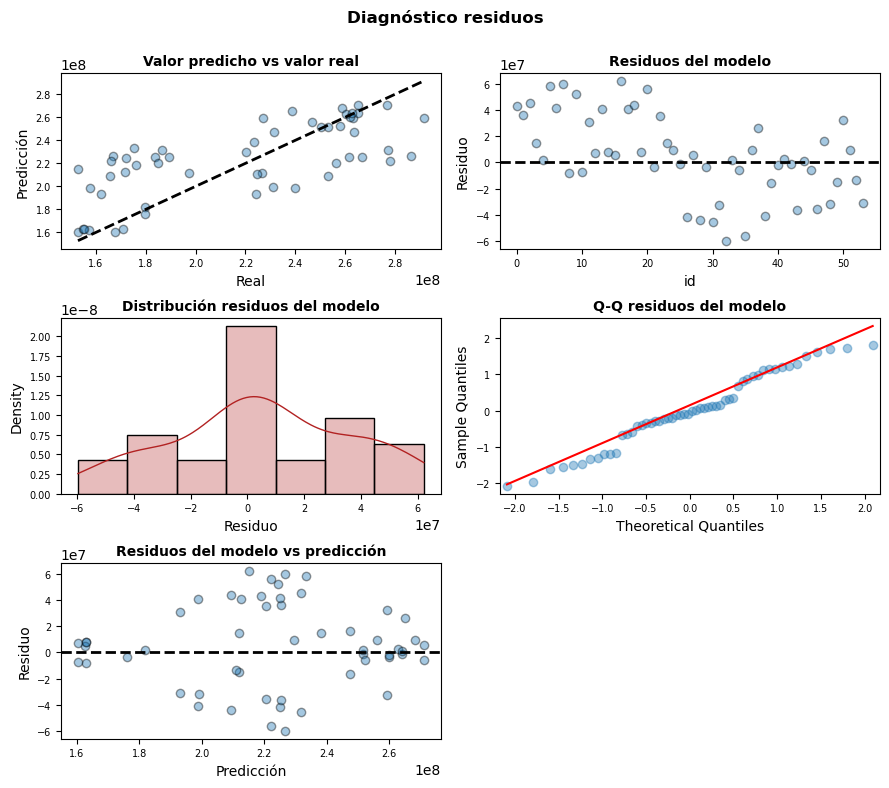

In [34]:
#Selección de variables
X = df_agrupation[['Precipitation', 'Temperature']]
y = df_agrupation['hectare']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.K_Nearest_Neighbour_Regressor(X_train, X_test, y_train, y_test)

[up](#id0)

<div id='id51' />

#### Random Forest

(MAE) Test Mean absolute error: 60243860.452
(MSE) Test mean squared error: 7761.692
Test R2 score: -6.142
-0.20261135296819988


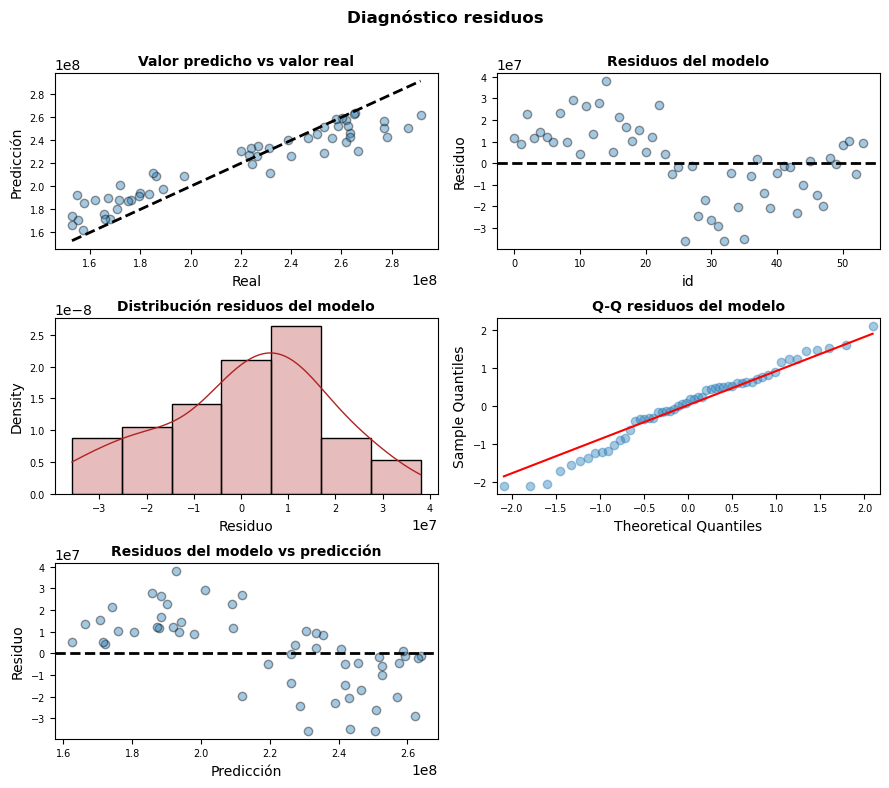

In [35]:
#Selección de variables
X = df_agrupation[['Precipitation', 'Temperature']]
y = df_agrupation['hectare']

#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.Random_Forest_regressor(X_train, X_test, y_train, y_test, criterion='friedman_mse', max_depth= 2, max_features='sqrt', n_estimators= 1)

[up](#id0)

<div id='id52' />

#### XGboost

(MAE) Test Mean absolute error: 59547902.106
(MSE) Test mean squared error: 7716.729
Test R2 score: -6.548


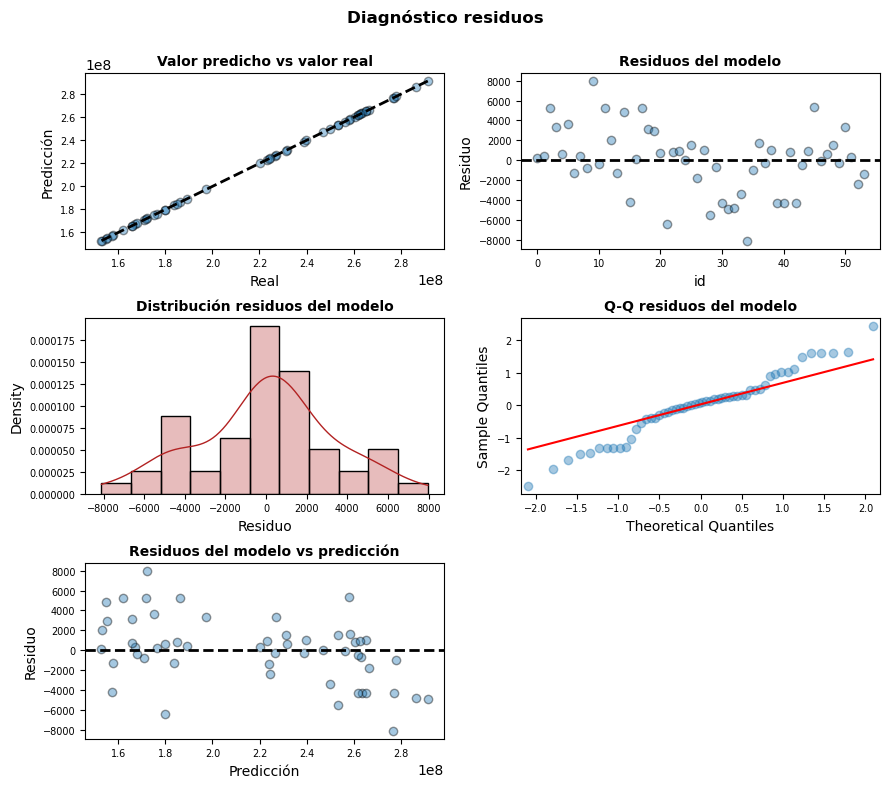

In [36]:
#Selección de variables
X = df_agrupation[['Precipitation', 'Temperature']]
y = df_agrupation['hectare']
#Creación de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train.shape, X_test.shape

#Aplicación del modelo
functions.XGB_Regressor(X_train, X_test, y_train, y_test, gamma=  0.00001, max_depth = 2, min_child_weight = 3, n_estimators = 5)

[up](#id0)

<div id='id54' />

### Resumen y comparativa de los Modelos

In [37]:
df = pd.read_excel('../DATOS/archivos creados analisis/Tabla_resumen_modelos.xlsx')
#df = pd.pivot_table(df, index=['Unnamed: 0', 'Unnamed: 1'], values=(['BARLEY', 'CORN', 'COTTON', 'OATS', 'SORHGHUM', 'OYBEANS', 'WEATH', 'GLOBAL']))
df.rename(columns={'Unnamed: 0': 'Model name', 'Unnamed: 1':'Measures'}, inplace = True)
df

Model name Measures        BARLEY          CORN  \
0                Regresión Lineal      MAE    5653825.79    5884698.85   
1                Regresión Lineal      MSE       2377.78       2425.84   
2                Regresión Lineal      R^2        -63.09         -3.64   
3   K Nearest Neighbour Regressor      MAE    7002686.54    7213471.74   
4   K Nearest Neighbour Regressor      MSE       2646.26       2685.79   
5   K Nearest Neighbour Regressor      R^2        -99.61         -5.85   
6                   Random Forest      MAE 5541145053.00 6070249981.00   
7                   Random Forest      MSE    2353964.00    2463788.00   
8                   Random Forest      R^2     -63809.00      -3751.00   
9                         XGBoost      MAE 5541341328.00 7030400704.00   
10                        XGBoost      MSE    2354005.00       2651.49   
11                        XGBoost      R^2     -68918.00      -6481.00   

          COTTON          OATS      SORHGHUM       OYBEANS          WEATH  \
0     3866640.06    6792566.94    4412091.05    7137175.84    69440009.27   
1        1966.38       2606.26       2100.50       2671.55        8333.07   
2          -3.16       -592.33        -11.71         -8.06         -12.49   
3     3643654.48    7554486.02    4706037.29    7759280.74    66399203.26   
4        1908.84       2748.54       2169.34       2785.55        8148.57   
5          -2.01       -855.56        -13.53         -9.78         -12.20   
6  3183521104.00 6950416896.00 4387695992.00 8984259871.00 63597414142.00   
7     1784242.00    2636364.00    2094683.00    2997375.00     7974799.00   
8       -1638.00    -666142.00     -11583.00     -11796.00         -10.31   
9     3481060.11 6728577807.00 4320066099.00 9879845191.00 57293014157.00   
10       1865.76       2593.95    2078477.00    3143222.00     7569215.00   
11      -2558.00    -644386.00     -11311.00     -17055.00       -8507.00   

           GLOBAL  
0     68011822.91  
1         8246.93  
2           -8.27  
3     55857893.72  
4         7473.81  
5           -5.64  
6  58607888339.00  
7      7655579.00  
8        -5902.00  
9  59547902106.00  
10     7716729.00  
11       -6548.00

In [53]:
df.to_excel('../DATOS/archivos creados analisis/models_results.xlsx')

In [38]:
MAE = df[df['Measures'] == 'MAE']
MAE.drop(columns='Measures', inplace = True)
MAE.set_index('Model name', inplace = True)
MAE = MAE.T

MSE = df[df['Measures'] == 'MSE']
MSE.drop(columns='Measures', inplace = True)
MSE.set_index('Model name', inplace = True)
MSE = MSE.T

R_2 = df[df['Measures'] == 'R^2']
R_2.drop(columns='Measures', inplace = True)
R_2.set_index('Model name', inplace = True)
R_2 = R_2.T

In [39]:
#MAE

fig = px.bar(MAE, x=['Regresión Lineal', 'K Nearest Neighbour Regressor'], barmode='group', text_auto='.2s', title='MAE', color_discrete_sequence=px.colors.qualitative.Dark2, height=500, width= 1100)
fig.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(legend=dict(yanchor="top", y=0.25, xanchor="left", x=0.744))

fig1 = px.bar(MAE, x=['Random Forest', 'XGBoost'], barmode='group', text_auto='.2s' ,title='MAE',color_discrete_sequence=px.colors.qualitative.G10, height=500, width= 1100)
fig1.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig1.update_layout(legend=dict(yanchor="top", y=0.25, xanchor="left", x=0.84))

fig.show()
fig1.show()

In [309]:
#MSE

fig = px.bar(MSE, x=['Regresión Lineal', 'K Nearest Neighbour Regressor'], barmode='group', text_auto='.2s', title='MSE', color_discrete_sequence=px.colors.qualitative.Dark2, height=500, width= 1100)
fig.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(legend=dict(yanchor="top", y=0.25, xanchor="left", x=0.744))

fig1 = px.bar(MSE, x=['Random Forest', 'XGBoost'], barmode='group', text_auto='.2s' ,title='MSE',color_discrete_sequence=px.colors.qualitative.G10, height=500, width= 1100)
fig1.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig1.update_layout(legend=dict(yanchor="top", y=0.25, xanchor="left", x=0.84))

fig.show()
fig1.show()

In [51]:
#R_2

fig = px.bar(R_2, x=['Regresión Lineal', 'K Nearest Neighbour Regressor'], barmode='group', text_auto='.2s', title='R_2', color_discrete_sequence=px.colors.qualitative.Dark2, height=500, width= 1100)
fig.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(legend=dict(yanchor="top", y=0.97, xanchor="left", x=0.01))

fig1 = px.bar(R_2, x=['Random Forest', 'XGBoost'], barmode='group', text_auto='.2s' ,title='R_2',color_discrete_sequence=px.colors.qualitative.G10, height=500, width= 1100)
fig1.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig1.update_layout(legend=dict(yanchor="top", y=0.97, xanchor="left", x=0.01))

fig.show()
fig1.show()

[up](#id0)

<div id='id53' />

## Concluiones

- Como se ve en los resultados de los modelos, en ningun caso han sabido predecir o acercarse a una prediccion similar a la de test. Esto es debido a que los datos en este caso son escasos. Siendo los modelos de regresión lineal y "K Nearest Neighbor" los que mayor acierto o han podido tener como se pueden observar en los indices de ajuste y las representaciones gráficas.